In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/JE_h09.wav
/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/KL_f12.wav
/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/DC_h03.wav
/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/DC_d04.wav
/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/KL_a14.wav
/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/JE_f01.wav
/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/KL_h15.wav
/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/JK_su02.wav
/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/JK_a06.wav
/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/DC_n01.wav
/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/DC_f01.wav
/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/JK_n22.wav
/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/KL_a10.wav
/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/JE

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/surrey-audiovisual-expressed-emotion-savee


In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    log_loss,
    matthews_corrcoef,
    cohen_kappa_score,
    brier_score_loss,
)

from transformers import AutoModelForAudioClassification, AutoFeatureExtractor
import warnings
warnings.filterwarnings('ignore')


# TESS and SAVEE Dataset Load for SER evaluation of models

In [4]:
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [5]:
tess_directory_list = os.listdir(Tess)

file_emotion_tess = []
file_path_tess = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion_tess.append('surprise')
        else:
            file_emotion_tess.append(part)
        file_path_tess.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion_tess, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path_tess, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())

Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


In [6]:
savee_directory_list = os.listdir(Savee)

file_emotion_savee = []
file_path_savee = []

for file in savee_directory_list:
    file_path_savee.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion_savee.append('angry')
    elif ele=='d':
        file_emotion_savee.append('disgust')
    elif ele=='f':
        file_emotion_savee.append('fear')
    elif ele=='h':
        file_emotion_savee.append('happy')
    elif ele=='n':
        file_emotion_savee.append('neutral')
    elif ele=='sa':
        file_emotion_savee.append('sad')
    else:
        file_emotion_savee.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion_savee, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path_savee, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())

Emotions
neutral     120
fear         60
happy        60
disgust      60
angry        60
surprise     60
sad          60
Name: count, dtype: int64


# Model Functions

In [7]:
# Define a function to load models dynamically based on the model ID
def load_model_and_extractor(model_id):
    model = AutoModelForAudioClassification.from_pretrained(model_id)
    feature_extractor = AutoFeatureExtractor.from_pretrained(model_id, do_normalize=True)
    id2label = model.config.id2label
    return model, feature_extractor, id2label


In [8]:

# Preprocess audio
def preprocess_audio(audio_path, feature_extractor, max_duration=30.0):
    audio_array, sampling_rate = librosa.load(audio_path, sr=feature_extractor.sampling_rate)
    
    max_length = int(feature_extractor.sampling_rate * max_duration)
    if len(audio_array) > max_length:
        audio_array = audio_array[:max_length]
    else:
        audio_array = np.pad(audio_array, (0, max_length - len(audio_array)))

    inputs = feature_extractor(
        audio_array,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=max_length,
        truncation=True,
        return_tensors="pt",
    )
    return inputs

# Predict emotion
def predict_emotion(audio_path, model, feature_extractor, id2label, max_duration=30.0):
    inputs = preprocess_audio(audio_path, feature_extractor, max_duration)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_id = torch.argmax(logits, dim=-1).item()
    predicted_label = id2label[predicted_id]
    
    return predicted_label

# Evaluation Functions
def calculate_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def calculate_precision_recall_f1(y_true, y_pred, average="weighted"):
    return precision_recall_fscore_support(y_true, y_pred, average=average)

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

def calculate_roc_auc(y_true, y_prob, multi_class="ovr", average="macro"):
    return roc_auc_score(y_true, y_prob, multi_class=multi_class, average=average)

def calculate_mcc(y_true, y_pred):
    return matthews_corrcoef(y_true, y_pred)

def calculate_cohens_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred)

# Main Evaluation Function
def evaluate_model(y_true, y_pred, y_prob, class_labels):
    accuracy = calculate_accuracy(y_true, y_pred)
    precision, recall, f1, _ = calculate_precision_recall_f1(y_true, y_pred)
    mcc = calculate_mcc(y_true, y_pred)
    cohen_kappa = calculate_cohens_kappa(y_true, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    print(f"Cohen's Kappa: {cohen_kappa:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, labels=class_labels, zero_division=0))

    print("\nConfusion Matrix:")
    plot_confusion_matrix(y_true, y_pred, class_labels)

    if y_prob is not None:
        try:
            roc_auc = calculate_roc_auc(y_true, y_prob)
            print(f"ROC AUC: {roc_auc:.4f}")
        except Exception as e:
            print(f"ROC AUC could not be computed: {e}")




In [9]:
from collections import defaultdict
import math

def get_emotion_sample(paths, labels, EVAL_SAMPLES=10):
    emotion_groups = defaultdict(list)

    # Group paths by emotion labels
    for i, label in enumerate(labels):
        emotion_groups[label].append(paths[i])

    # Ensure equal distribution of samples
    num_emotions = len(emotion_groups)
    samples_per_emotion = math.floor(EVAL_SAMPLES / num_emotions)

    limited_paths = []
    limited_labels = []

    # Collect equal samples for each emotion, ensuring we don't exceed EVAL_SAMPLES
    for emotion, paths_group in emotion_groups.items():
        # Use only 'samples_per_emotion' samples from each group
        limited_paths.extend(paths_group[:samples_per_emotion])
        limited_labels.extend([emotion] * samples_per_emotion)

    # If there are remaining samples needed, collect from emotion groups
    remaining_samples_needed = EVAL_SAMPLES - len(limited_paths)
    if remaining_samples_needed > 0:
        # Flatten emotion groups and pick additional samples
        remaining_samples = [
            path
            for paths_group in emotion_groups.values()
            for path in paths_group[samples_per_emotion:]  # Skip already selected samples
        ]
        limited_paths.extend(remaining_samples[:remaining_samples_needed])
        limited_labels.extend(labels[:remaining_samples_needed])  # Or use the corresponding labels for remaining paths

    return limited_paths, limited_labels


# Label Mapper

In [10]:
# Define label mapper
label_mapper = {
    'fearful': 'fear',
    'angry': 'angry',
    'happy': 'happy',
    'surprised': 'surprise',
    'sad': 'sad',
    'disgust': 'disgust',
    'neutral': 'neutral'
}

# Model Evaluation Function

In [11]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
import torch
from os.path import basename

def evaluate_emotion_model(limited_paths, limited_labels, model, feature_extractor, id2label, label_mapper, eval_samples):
    """
    Function to evaluate an emotion classification model.
    
    Parameters:
        limited_paths (list): List of file paths to audio samples.
        limited_labels (list): List of corresponding true emotion labels.
        model (torch.nn.Module): The trained model to use for prediction.
        feature_extractor: Preprocessing function for audio samples.
        id2label (dict): Mapping from model output IDs to emotion labels.
        label_mapper (dict): Dictionary to map predicted labels to true labels.
        eval_samples (int): Number of samples to evaluate.
    """
    
    # Initialize variables
    predicted_labels = []
    true_labels = []
    y_prob = []
    results = []
    
    print(f"\nStarting Evaluation for {eval_samples} samples:\n")
    
    # Iterate through the samples and predict the emotions
    for i, audio_path in enumerate(tqdm(limited_paths[:eval_samples], desc="Evaluating", unit="sample")):
        # Predict emotion
        predicted_label = predict_emotion(audio_path, model, feature_extractor, id2label)

        # Apply label mapper to maintain consistency
        predicted_label = label_mapper.get(predicted_label.lower(), predicted_label.lower())
        true_label = label_mapper.get(limited_labels[i].lower(), limited_labels[i].lower())

        # Append predicted and true labels
        predicted_labels.append(predicted_label)
        true_labels.append(true_label)

        # Store result
        results.append({
            "Sample": i + 1,
            "File": basename(audio_path),
            "Predicted Emotion": predicted_label,
            "True Emotion": true_label
        })

    # Print Final Evaluation Results
    print("\nFinal Evaluation Results:")
    print(tabulate(results, headers="keys", tablefmt="grid"))

    # Generate Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    print("\nConfusion Matrix:\n")
    print(cm)

    # Call an external evaluation function (if defined)
    evaluate_model(true_labels, predicted_labels, y_prob, list(label_mapper.values()))



# Evaluation of model - openai-whisper

In [12]:
# Example usage - change model_id to load the other model if necessary
model_id = "firdhokk/speech-emotion-recognition-with-openai-whisper-large-v3"
model_whisper, feature_extractor_whisper, id2label_whisper = load_model_and_extractor(model_id)


config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.55G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

## Whisper With TESS Dataset


Starting Evaluation for 2800 samples:



Evaluating: 100%|██████████| 2800/2800 [20:06<00:00,  2.32sample/s]



Final Evaluation Results:
+----------+-------------------------+---------------------+----------------+
|   Sample | File                    | Predicted Emotion   | True Emotion   |
+==========+=========================+=====================+================+
|        1 | YAF_home_fear.wav       | fear                | fear           |
+----------+-------------------------+---------------------+----------------+
|        2 | YAF_youth_fear.wav      | fear                | fear           |
+----------+-------------------------+---------------------+----------------+
|        3 | YAF_near_fear.wav       | fear                | fear           |
+----------+-------------------------+---------------------+----------------+
|        4 | YAF_search_fear.wav     | fear                | fear           |
+----------+-------------------------+---------------------+----------------+
|        5 | YAF_pick_fear.wav       | fear                | fear           |
+----------+-------------------------

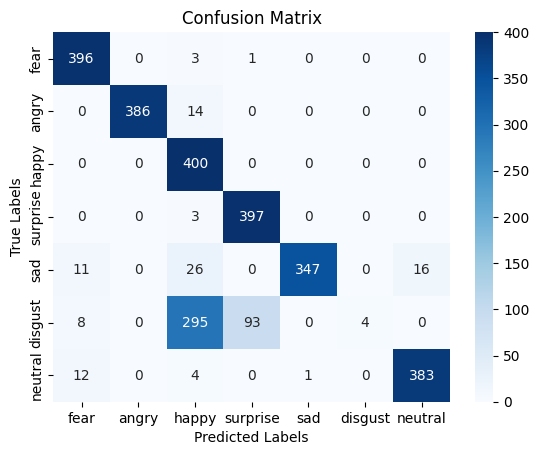

ROC AUC could not be computed: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.


In [13]:
limited_paths = file_path_tess
limited_labels = file_emotion_tess
model = model_whisper
feature_extractor = feature_extractor_whisper
id2label = id2label_whisper
label_mapper = label_mapper
eval_samples = 2800

evaluate_emotion_model(limited_paths, limited_labels, model, feature_extractor, id2label, label_mapper, eval_samples)

## Whisper With SAVEE Dataset


Starting Evaluation for 480 samples:



Evaluating: 100%|██████████| 480/480 [03:27<00:00,  2.32sample/s]



Final Evaluation Results:
+----------+-------------+---------------------+----------------+
|   Sample | File        | Predicted Emotion   | True Emotion   |
+==========+=============+=====================+================+
|        1 | JE_h09.wav  | happy               | happy          |
+----------+-------------+---------------------+----------------+
|        2 | KL_f12.wav  | surprise            | fear           |
+----------+-------------+---------------------+----------------+
|        3 | DC_h03.wav  | fear                | happy          |
+----------+-------------+---------------------+----------------+
|        4 | DC_d04.wav  | surprise            | disgust        |
+----------+-------------+---------------------+----------------+
|        5 | KL_a14.wav  | neutral             | angry          |
+----------+-------------+---------------------+----------------+
|        6 | JE_f01.wav  | fear                | fear           |
+----------+-------------+---------------------+-

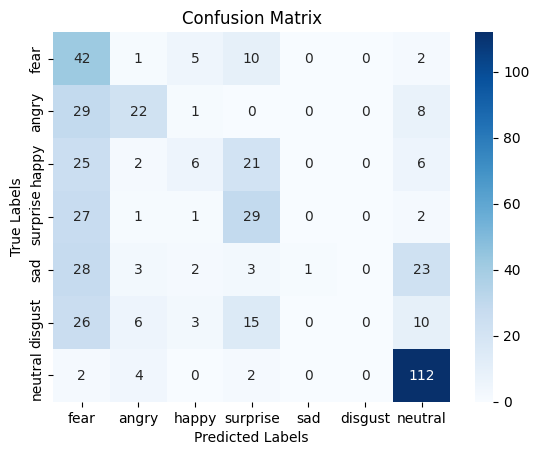

ROC AUC could not be computed: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.


In [14]:
limited_paths = file_path_savee
limited_labels = file_emotion_savee
model = model_whisper
feature_extractor = feature_extractor_whisper
id2label = id2label_whisper
label_mapper = label_mapper
eval_samples = 480

evaluate_emotion_model(limited_paths, limited_labels, model, feature_extractor, id2label, label_mapper, eval_samples)

# Evaluation of model facebook-wav2vec2

In [15]:
# Alternatively, if you want to load the other model
model_id = "firdhokk/speech-emotion-recognition-with-facebook-wav2vec2-large-xlsr-53"
model_wav2vec2, feature_extractor_wav2vec2, id2label_wav2vec2 = load_model_and_extractor(model_id)


config.json:   0%|          | 0.00/2.65k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

## With TESS Dataset


Starting Evaluation for 2800 samples:



Evaluating: 100%|██████████| 2800/2800 [12:05<00:00,  3.86sample/s]



Final Evaluation Results:
+----------+-------------------------+---------------------+----------------+
|   Sample | File                    | Predicted Emotion   | True Emotion   |
+==========+=========================+=====================+================+
|        1 | YAF_home_fear.wav       | surprise            | fear           |
+----------+-------------------------+---------------------+----------------+
|        2 | YAF_youth_fear.wav      | surprise            | fear           |
+----------+-------------------------+---------------------+----------------+
|        3 | YAF_near_fear.wav       | surprise            | fear           |
+----------+-------------------------+---------------------+----------------+
|        4 | YAF_search_fear.wav     | surprise            | fear           |
+----------+-------------------------+---------------------+----------------+
|        5 | YAF_pick_fear.wav       | surprise            | fear           |
+----------+-------------------------

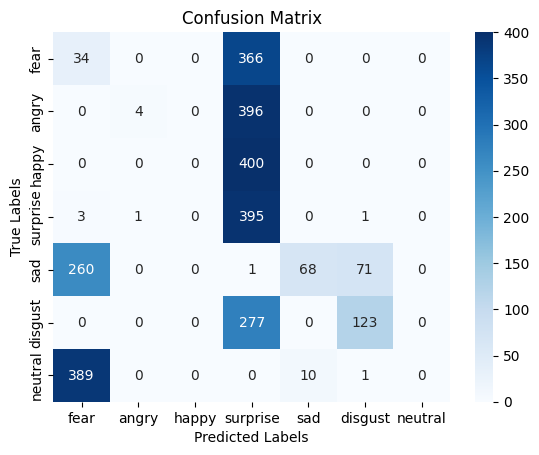

ROC AUC could not be computed: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.


In [16]:
limited_paths = file_path_tess
limited_labels = file_emotion_tess
model = model_wav2vec2
feature_extractor = feature_extractor_wav2vec2
id2label = id2label_wav2vec2
label_mapper = label_mapper
eval_samples = 2800

evaluate_emotion_model(limited_paths, limited_labels, model, feature_extractor, id2label, label_mapper, eval_samples)

## With SAVEE Dataset


Starting Evaluation for 480 samples:



Evaluating: 100%|██████████| 480/480 [02:04<00:00,  3.84sample/s]



Final Evaluation Results:
+----------+-------------+---------------------+----------------+
|   Sample | File        | Predicted Emotion   | True Emotion   |
+==========+=============+=====================+================+
|        1 | JE_h09.wav  | surprise            | happy          |
+----------+-------------+---------------------+----------------+
|        2 | KL_f12.wav  | surprise            | fear           |
+----------+-------------+---------------------+----------------+
|        3 | DC_h03.wav  | surprise            | happy          |
+----------+-------------+---------------------+----------------+
|        4 | DC_d04.wav  | surprise            | disgust        |
+----------+-------------+---------------------+----------------+
|        5 | KL_a14.wav  | surprise            | angry          |
+----------+-------------+---------------------+----------------+
|        6 | JE_f01.wav  | surprise            | fear           |
+----------+-------------+---------------------+-

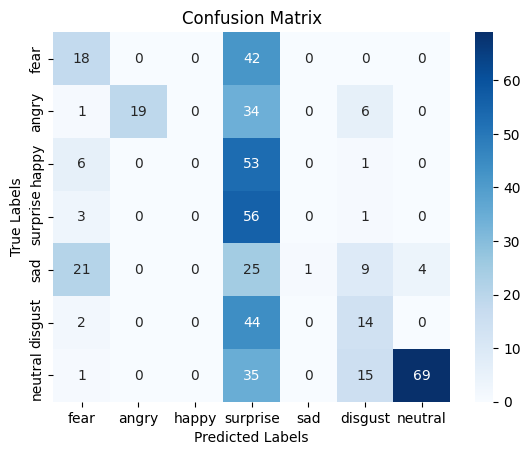

ROC AUC could not be computed: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.


In [17]:
limited_paths = file_path_savee
limited_labels = file_emotion_savee
model = model_wav2vec2
feature_extractor = feature_extractor_wav2vec2
id2label = id2label_wav2vec2
label_mapper = label_mapper
eval_samples = 480

evaluate_emotion_model(limited_paths, limited_labels, model, feature_extractor, id2label, label_mapper, eval_samples)